In [1]:
%%javascript
/**********************************************************************************************
Known Mathjax Issue with Chrome - a rounding issue adds a border to the right of mathjax markup
https://github.com/mathjax/MathJax/issues/1300
A quick hack to fix this based on stackoverflow discussions: 
http://stackoverflow.com/questions/34277967/chrome-rendering-mathjax-equations-with-a-trailing-vertical-line
**********************************************************************************************/

$('.math>span').css("border-left-color","transparent")

<IPython.core.display.Javascript object>

In [2]:
%reload_ext autoreload
%autoreload 2

In [3]:
# Start Spark (should only have to do this once)

import sys 
import pyspark

from pyspark.sql import SQLContext

app_name = "example-logs"
master = "local[*]"
conf = pyspark.SparkConf().setAppName(app_name).setMaster(master)
sc = pyspark.SparkContext(conf=conf)
sqlContext = SQLContext(sc)

# DAMLAS - Machine Learning At Scale
## Assignment - HW3
Data Analytics and Machine Learning at Scale
Target, Minneapolis

---
__Name:__  Renee Murray

__Class:__ DAMLAS (Section Summer 2016 - TARGET, e.g., Summer 2016)     

__Email:__  renee.murray@Target.com    

__Week:__   03

# Table of Contents <a name="TOC"></a> 

1.  [HW Introduction](#1)   
2.  [HW References](#2)
3.  [HW Problems](#3)   
    3.0.  [Short Answer Questions](#HW3.0)    
    3.1.  [Word Count plus sorting](#HW3.1)   
    3.2.  [MLlib-centric Kmeans](#HW3.2)    
    3.3.  [Homegrown KMeans in Spark](#HW3.3)    
    3.4.  [Making Homegrown KMeans more efficient](#HW3.4)  
    3.5.  [OPTIONAL Weighted KMeans](#HW3.5)  
    3.6.  [OPTIONAL Linear Regression](#HW3.6)  
    3.7.  [OPTIONAL Error surfaces](#HW3.7)



<a name="1">
# 1 Instructions
[Back to Table of Contents](#TOC)
* Homework submissions are due by Tueday, 08/02/2016 at 11AM (CT).


* Prepare a single Jupyter note, please include questions, and question numbers in the questions and in the responses.
Submit your homework notebook via the following form:

   + [Submission Link - Google Form](http://goo.gl/forms/er3OFr5eCMWDngB72)


### Documents:
* IPython Notebook, published and viewable online.
* PDF export of IPython Notebook.
    
<a name="2">
# 2 Useful References
[Back to Table of Contents](#TOC)

* Karau, Holden, Konwinski, Andy, Wendell, Patrick, & Zaharia, Matei. (2015). Learning Spark: Lightning-fast big data analysis. Sebastopol, CA: O’Reilly Publishers.
* Hastie, Trevor, Tibshirani, Robert, & Friedman, Jerome. (2009). The elements of statistical learning: Data mining, inference, and prediction (2nd ed.). Stanford, CA: Springer Science+Business Media. __(Download for free [here](http://statweb.stanford.edu/~tibs/ElemStatLearn/printings/ESLII_print10.pdf))__
* Ryza, Sandy, Laserson, Uri, Owen, Sean, & Wills, Josh. (2015). Advanced analytics with Spark: Patterns for learning from data at scale. Sebastopol, CA: O’Reilly Publishers.
---
* [Slides for Supervised-ML-Classification-via-GradientDescent](https://www.dropbox.com/s/uzoch1dwft8kaqw/Lecture-15-Supervised-ML-Classification-via-GradientDescent.pdf?dl=0)
* [Slides from High Entropy Friday]( https://www.dropbox.com/s/0dlvsff3660vvbk/Lecture-High-Entropy-Friday.pdf?dl=0)

---

<a name="HW3">
# 3 HW Problems
[Back to Table of Contents](#TOC)

<a name="3.0"></a><h2 style="color:darkblue"> HW3.0: Short answer questions </h2>
[Back to Table of Contents](#TOC)


__What is Apache Spark and how is it different to Apache Hadoop? __

Spark is another map reduce framework that out performs Hadoop because of how it handles information in memory vs on disk. Spark processes data in-memory. Hadoop sends data back to disk after a map or reduce function. By holding that informatino in memory, Spark is able to outperform Hadoop. Note that this requires a lot of memory. If memory becomes an issue, Spark performance will go down drastically. Hadoop MapReduce kills processes as soon as a job is done, so it is not as taxing on memory. So Spark is better when all the data can fit into memory, but Hadoop is better when it doesn't. There are other ways they differ, but this is the reason that Spark is typically faster. 

__Fill in the blanks:
Spark API consists of interfaces to develop applications based on it in Java, __ Scala, Python __ languages (list languages). There is also SparkR for R support. __

<hr>

__Using Spark, resource management can be done either in a single server instance or using a framework such as Mesos or __ Yarn __ in a distributed manner. __

<hr>

__What is an RDD and show a fun example of creating one and bringing the first element back to the driver program. __

RDD = Resilient Distributed Dataset = immutable distributed collection of objects. 

<hr>


In [4]:
%%writefile example.txt
A data analyst is on board a passenger jet
The captain’s voice announced over the radio 
"We have lost an engine, but there’s no need to worry, we can fly on three engines, it will just take us an hour longer to reach our destination."
A while later, the radio crackles again:
“This is your captain speaking, we have lost another engine – but we’re in no danger. Our journey will take an extra two hours though.”
Not long after, the captain is on the radio again: 
“We’re down to one engine, we can make it safely, but we’re going to be landing three hours late.”
“I hope we don’t lose the last engine,” says the analyst, “We’ll be up here forever.”

Writing example.txt


In [5]:
rdd = sc.textFile("example.txt")
rdd.first()

u'A data analyst is on board a passenger jet'

<a name="HW3.1"> <h2 style="color:darkgreen">HW3.1 WordCount plus sorting </h2>
[Back to Table of Contents](#TOC)

The following notebooks will be useful to jumpstart this collection of Homework exercises:


* [Example Notebook with Debugging tactics in Spark](http://nbviewer.jupyter.org/urls/dl.dropbox.com/s/jqjllp8kmf1eolk/WordCountDebugging-Example.ipynb)
* [Word Count Quiz](http://nbviewer.jupyter.org/urls/dl.dropbox.com/s/vgmpivsi4rvqz0s/WordCountQuiz.ipynb)
* [Work Count Solution](http://nbviewer.jupyter.org/urls/dl.dropbox.com/s/dxv3dmp1vluuo8i/WordCountQuiz-Solution.ipynb)

---
In Spark write the code to count how often each word appears in a text document (or set of documents). Please use this homework document (with no solutions in it) as a the example document to run an experiment.  Report the following: 
* provide a sorted list of tokens in decreasing order of frequency of occurence limited to [top 20 most frequent only] and [bottom 10 least frequent]. 


__OPTIONAL__ 
Feel free to do a secondary sort where words with the same frequncy are sorted alphanumerically increasing. Plseas refer to the [following notebook](http://nbviewer.jupyter.org/urls/dl.dropbox.com/s/uu5afr3ufpm9fy8/SecondarySort.ipynb)
 for examples of secondary sorts in Spark. Please provide the following [top 20 most frequent terms only] and [bottom 10 least frequent terms]

__NOTE__ [Please incorporate all referenced notebooks directly into this master notebook as cells for HW submission. I.e., HW submissions should comprise of just one notebook]__

In [6]:
def remove_punctuation(text):
    """
    Removes punctuation, and strips leading and trailing spaces.
    """
    return re.sub('[^A-Za-z0-9]+', ' ', text.strip().encode('utf8'))

def is_valid_word(word):
    """
    Return True or False on if this is a word I want included
    """
    try:
        int(word)
        return False
    except:
        return True

In [7]:
import re

counts = sc.textFile('HW3_WordCount_text.txt') \
        .map(remove_punctuation) \
        .map(lambda x: x.lower()) \
        .flatMap(lambda x: x.split()) \
        .filter(is_valid_word) \
        .map(lambda x: (x, 1)) \
        .reduceByKey(lambda x, y: x + y) \
        .map(lambda x:(x[1], x[0])) \
        .sortByKey(False)

word_counts = counts.collect()
    
print('Most frequent 20 words: ', word_counts[:20])
print('Least frequent 10 words: ', word_counts[len(word_counts) - 10:])


### Need to add in the secondary sort

('Most frequent 20 words: ', [(75, 'the'), (50, 'of'), (40, 'and'), (34, 'in'), (33, 'to'), (26, 'a'), (23, 'kmeans'), (22, 'data'), (21, 'code'), (19, 'hw3'), (18, 'here'), (17, 'for'), (17, 'with'), (17, 'this'), (17, 'contents'), (17, 'table'), (17, 'back'), (15, 'notebook'), (14, 'as'), (14, 'plot')])
('Least frequent 10 words: ', [(1, 'assignment'), (1, 'user'), (1, 'jumpstart'), (1, 'class'), (1, 'possibly'), (1, 'look'), (1, 'uri'), (1, 'element'), (1, 'patterns'), (1, 'left')])


<a name="HW3.1.1"><h2 style="color:darkgreen">HW3.1.1 </h2>
[Back to Table of Contents](#TOC)

Modify the above word count code to count words that begin with lower case letters (a-z) and report your findings. Again sort the output words in decreasing order of frequency.


In [8]:
import re

counts2 = sc.textFile('HW3_WordCount_text.txt') \
        .map(remove_punctuation) \
        .flatMap(lambda line: re.findall(r'\b[a-z]\w+\b', line)) \
        .filter(is_valid_word) \
        .map(lambda x: (x, 1)) \
        .reduceByKey(lambda x, y: x + y) \
        .map(lambda x:(x[1], x[0])) \
        .sortByKey(False)

word_counts2 = counts2.collect()
    
print('Most frequent 20 words: ', word_counts2[:20])
print('Least frequent 10 words: ', word_counts2[len(word_counts2) - 10:])

('Most frequent 20 words: ', [(71, 'the'), (49, 'of'), (40, 'and'), (33, 'to'), (32, 'in'), (20, 'data'), (17, 'for'), (17, 'with'), (17, 'this'), (14, 'as'), (12, 'here'), (12, 'model'), (12, 'code'), (12, 'plot'), (12, 'notebook'), (10, 'is'), (9, 'goes'), (9, 'clusters'), (9, 'space'), (8, 'your')])
('Least frequent 10 words: ', [(1, 'online'), (1, 'such'), (1, 'two'), (1, 'initializationMode'), (1, 'github'), (1, 'possibly'), (1, 'element'), (1, 'graphs'), (1, 'first'), (1, 'left')])


<a name="HW3.2"> <h2 style="color:darkblue"> HW3.2: MLlib-centric KMeans</h2>
[Back to Table of Contents](#TOC)

Using the following  MLlib-centric KMeans code snippet: 

<pre>
from pyspark.mllib.clustering import KMeans, KMeansModel
from numpy import array
from math import sqrt


# Load and parse the data
# NOTE  kmeans_data.txt is available here 
#          https://www.dropbox.com/s/q85t0ytb9apggnh/kmeans_data.txt?dl=0 
data = sc.textFile("kmeans_data.txt")  
parsedData = data.map(lambda line: array([float(x) for x in line.split(' ')]))

# Build the model (cluster the data)
clusters = KMeans.train(parsedData, 2, maxIterations=10,
        runs=10, initializationMode="random")

# Evaluate clustering by computing Within Set Sum of Squared Errors
def error(point):
    center = clusters.centers[clusters.predict(point)]
    return sqrt(sum([x**2 for x in (point - center)]))

WSSSE = parsedData.map(lambda point: error(point)).reduce(lambda x, y: x + y)
print("Within Set Sum of Squared Error = " + str(WSSSE))

# Save and load model
clusters.save(sc, "myModelPath")
sameModel = KMeansModel.load(sc, "myModelPath")

</pre>

__NOTE__ <p> The  __kmeans_data.txt__ is available here https://www.dropbox.com/s/q85t0ytb9apggnh/kmeans_data.txt?dl=0 

__TASKS__
* Run this code snippet and list the clusters that your find.
* compute the Within Set Sum of Squared Errors for the found clusters. Comment on your findings.

In [9]:
!curl -L https://www.dropbox.com/s/q85t0ytb9apggnh/kmeans_data.txt?dl=0 -o kmeans_data.txt

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100    72  100    72    0     0     44      0  0:00:01  0:00:01 --:--:--     0


In [10]:
from pyspark.mllib.clustering import KMeans, KMeansModel
from numpy import array
from math import sqrt
import shutil
import os

# Checks to see if myModelPath exists and if so deletes it (allows running cell multiple times w/o errors)
if os.path.exists('myModelPath') == True:
    shutil.rmtree('myModelPath')

data = sc.textFile("kmeans_data.txt")  
parsedData = data.map(lambda line: array([float(x) for x in line.split(' ')]))

# Build the model (cluster the data)
clusters = KMeans.train(parsedData, 2, maxIterations=10,
        runs=10, initializationMode="random")

# Evaluate clustering by computing Within Set Sum of Squared Errors
def error(point):
    center = clusters.centers[clusters.predict(point)]
    return sqrt(sum([x**2 for x in (point - center)]))

WSSSE = parsedData.map(lambda point: error(point)).reduce(lambda x, y: x + y)
WCSS = clusters.computeCost(parsedData)

print("WSSSE = " + str(WSSSE))
print("WCSS " + str(WCSS)) 
print("Centroids: " + str(clusters.centers))

# Save and load model
clusters.save(sc, "myModelPath")
sameModel = KMeansModel.load(sc, "myModelPath")

/usr/local/spark/python/pyspark/mllib/clustering.py:176: UserWarning: Support for runs is deprecated in 1.6.0. This param will have no effect in 1.7.0.
  "Support for runs is deprecated in 1.6.0. This param will have no effect in 1.7.0.")


WSSSE = 0.692820323028
WCSS 0.12
Centroids: [array([ 9.1,  9.1,  9.1]), array([ 0.1,  0.1,  0.1])]


### The code above results in 2 clusters as that is pre-set in the KMeans train code. Error is low indicating this is a good model for the data. 

<a name="HW3.3"><h2 style="color:darkgreen"> HW3.3: Homegrown KMeans in Spark </h2>
[Back to Table of Contents](#TOC)

Download the following KMeans [notebook](http://nbviewer.jupyter.org/urls/dl.dropbox.com/s/3nsthvp8g2rrrdh/EM-Kmeans.ipynb).

Generate 3 clusters with 100 (one hundred) data points per cluster (using the code provided). Plot the data.
Then run MLlib's Kmean implementation on this data  and report your results as follows:

* plot the resulting clusters after 1 iteration, 10 iterations, after 20 iterations, after 100 iterations.
* in each plot please report the Within Set Sum of Squared Errors for the found clusters (as part of the title WSSSE). Comment on the progress of this measure as  the KMEans algorithms runs for more iterations. Then plot the WSSSE as a function of the iteration (1, 10, 20, 30, 40, 50, 100).



In [11]:
 %matplotlib inline
    
import numpy as np
import pylab 
import json

size1 = size2 = size3 = 100

samples1 = np.random.multivariate_normal([4, 0], [[1, 0],[0, 1]], size1)
data = samples1

samples2 = np.random.multivariate_normal([6, 6], [[1, 0],[0, 1]], size2)
data = np.append(data, samples2, axis = 0)

samples3 = np.random.multivariate_normal([0, 4], [[1, 0],[0, 1]], size3)
data = np.append(data, samples3, axis= 0)
# Randomlize data

data = data[np.random.permutation(size1 + size2 + size3),]
np.savetxt('data.csv', data, delimiter = ',')

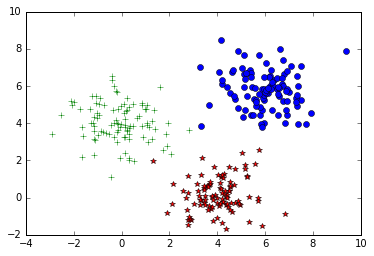

In [12]:
pylab.plot(samples1[:, 0], samples1[:, 1],'*', color = 'red')
pylab.plot(samples2[:, 0], samples2[:, 1],'o',color = 'blue')
pylab.plot(samples3[:, 0], samples3[:, 1],'+',color = 'green')
pylab.show()

In [13]:
# plot centroids and data points for each iteration
def plot_iteration(means):
    pylab.plot(samples1[:, 0], samples1[:, 1], '.', color = 'blue')
    pylab.plot(samples2[:, 0], samples2[:, 1], '.', color = 'blue')
    pylab.plot(samples3[:, 0], samples3[:, 1], '.', color = 'blue')
    pylab.plot(means[0][0], means[0][1], '*', markersize =10, color = 'red')
    pylab.plot(means[1][0], means[1][1], '*', markersize =10, color = 'red')
    pylab.plot(means[2][0], means[2][1], '*', markersize =10, color = 'red')
    pylab.show()

('Max iterations: ', 1)
WSSSE = 591.587595083
WCSS = 1492.17666978
Clusters: [array([ 4.65804435,  0.29587214]), array([ 4.46459694,  5.47380777]), array([ 1.28216206,  1.8970495 ])]


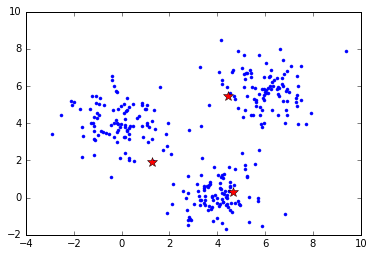

('Max iterations: ', 10)
WSSSE = 362.741686164
WCSS = 588.627420036
Clusters: [array([ 4.0284519 ,  0.14377491]), array([ 5.97821446,  5.80188381]), array([-0.07896696,  4.0134803 ])]


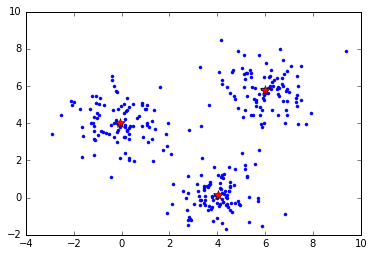

('Max iterations: ', 20)
WSSSE = 362.741686164
WCSS = 588.627420036
Clusters: [array([ 4.0284519 ,  0.14377491]), array([ 5.97821446,  5.80188381]), array([-0.07896696,  4.0134803 ])]


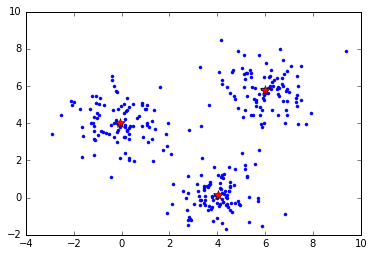

('Max iterations: ', 100)
WSSSE = 362.741686164
WCSS = 588.627420036
Clusters: [array([ 4.0284519 ,  0.14377491]), array([ 5.97821446,  5.80188381]), array([-0.07896696,  4.0134803 ])]


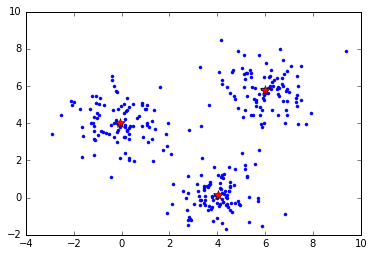

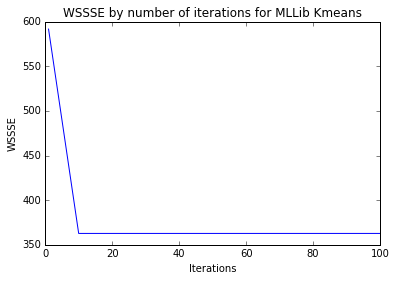

In [14]:
from pyspark.mllib.clustering import KMeans, KMeansModel
from numpy import array
from math import sqrt
import pylab as plt
import pandas as pd
import shutil
import os

max_iterations = 100
previous_clusters = None
WSSSE_records = []
iterations = [1, 10, 20, 30, 40, 50, 100]

data = sc.textFile("data.csv") \
    .map(lambda line: array([float(x) for x in line.split(',')])) \
    .cache()

for i in range(max_iterations):
    # Build the model (cluster the data)
    iteration = i + 1
    clusters = KMeans.train(
        data, 3, 
        maxIterations=1,
        initializationMode="random", 
        initialModel=previous_clusters
    )
    previous_clusters = clusters
    
    if iteration in [1, 10, 20, 30, 40, 50, 100]:
        WSSSE = data.map(lambda point: error(point)).reduce(lambda x, y: x + y)
        WCSS = clusters.computeCost(data)
        WSSSE_records.append(WSSSE)

    if iteration in [1, 10, 20, 100]:
        print("Max iterations: ", iteration)
        print("WSSSE = " + str(WSSSE))
        print("WCSS = " + str(WCSS)) 
        print("Clusters: " + str(clusters.centers))
        plot_iteration(clusters.centers)
        
plt.plot(iterations, WSSSE_records)
plt.title("WSSSE by number of iterations for MLLib Kmeans")
plt.xlabel("Iterations")
plt.ylabel("WSSSE")
plt.show()

### WSSSE quickly drops down to about 390 and then no longer improves. This indicates that we have achived the best fit for this data with this many clusters at thsi point as the model is not able to improve fit with more iterations. 

<a name="HW3.4"><h2 style="color:darkblue"> HW3.4: KMeans Experiments  </h2>
[Back to Table of Contents](#TOC)

Using this provided [homegrown Kmeans code](http://nbviewer.jupyter.org/urls/dl.dropbox.com/s/3nsthvp8g2rrrdh/EM-Kmeans.ipynb)   repeat the experiments in HW3.3. Explain any differences between the results in HW3.3 and HW3.4. 

In [15]:
import numpy as np

def nearest_centroid_hg(centroids_hg, line):
    x = np.array([float(f) for f in line.split(',')])
    closest_centroid_hg = np.sum((x - centroids_hg)**2, axis = 1).argmin()
    return (closest_centroid_hg, (x, 1))

def error_hg(centroids_hg, line):
    x = np.array([float(f) for f in line.split(',')])
    closest_centroid_hg = np.sum((x - centroids_hg)**2, axis = 1).argmin()
    error_hg = sqrt(np.sum((x - centroids_hg[closest_centroid_hg])**2))
    return (closest_centroid_hg, error_hg)

Iteration: 1
WSSSE = 1065.6197681
Centroids: [array([ 4.0284519 ,  0.14377491]), array([ 5.97821446,  5.80188381]), array([-0.07896696,  4.0134803 ])]


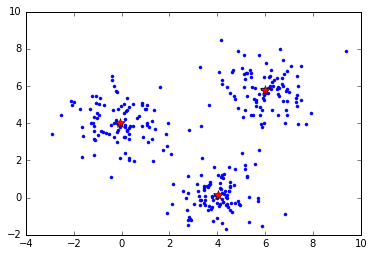

Iteration: 10
WSSSE = 362.741686164
Centroids: [array([ 4.0284519 ,  0.14377491]), array([ 5.97821446,  5.80188381]), array([-0.07896696,  4.0134803 ])]


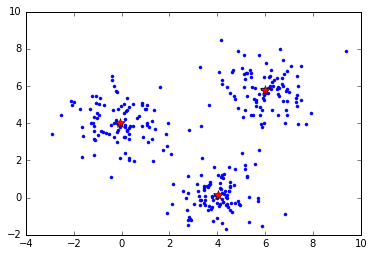

Iteration: 20
WSSSE = 362.741686164
Centroids: [array([ 4.0284519 ,  0.14377491]), array([ 5.97821446,  5.80188381]), array([-0.07896696,  4.0134803 ])]


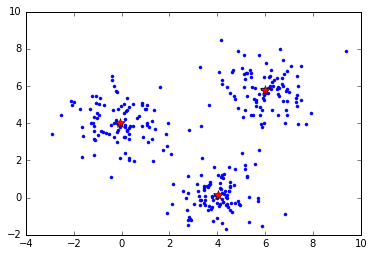

Iteration: 100
WSSSE = 362.741686164
Centroids: [array([ 4.0284519 ,  0.14377491]), array([ 5.97821446,  5.80188381]), array([-0.07896696,  4.0134803 ])]


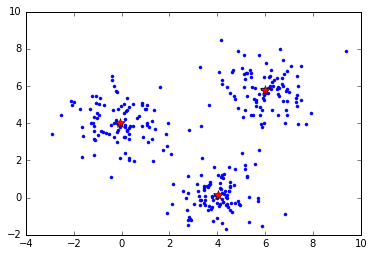

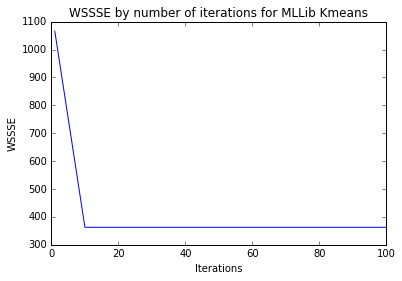

26.7491140366 seconds


In [16]:
from timeit import default_timer as timer
from functools import partial

start = timer()

centroids_hg = np.array([[0.0,0.0],[2.0,2.0],[0.0,7.0]])

WSSSE_report = []
iterations = [1, 10, 20, 30, 40, 50, 100]

data = sc.textFile("data.csv").cache()

for i in range(100): 
    iteration = i + 1
    nearest_centroid_bound = partial(nearest_centroid_hg, centroids_hg)
    error_bound = partial(error_hg, centroids_hg)
    res = data.map(nearest_centroid_bound).reduceByKey(lambda x, y: (x[0] + y[0], x[1] + y[1])).collect()
    res = sorted(res, key = lambda x : x[0])  #sort based on clusted ID
    centroids_new_hg = np.array([x[1][0] / x[1][1] for x in res])  #divide by cluster size
#     if np.sum(np.absolute(centroids_new_hg - centroids_hg)) < 0.01:
#         break
    centroids_hg = centroids_new_hg
    WSSSE_hg = data.map(error_bound).reduceByKey(lambda x, y: x + y).collect()
    
    sum_WSSSE = 0
    
    for WSSSE in WSSSE_hg:
        sum_WSSSE += WSSSE[1]
    
    if iteration in [1, 10, 20, 100]:
        print("Iteration: " + str(iteration))
        print("WSSSE = " + str(sum_WSSSE))
        print("Centroids: " + str(clusters.centers))
        plot_iteration(clusters.centers)
    
    if iteration in iterations:
        WSSSE_report.append(sum_WSSSE)
        
plt.plot(iterations, WSSSE_report)
plt.title("WSSSE by number of iterations for MLLib Kmeans")
plt.xlabel("Iterations")
plt.ylabel("WSSSE")
plt.show()

end = timer()

print(str(end - start) + " seconds" )

### In this example we had to write a for loop to tell Spark what to do over the iterations and how many iterations. In MLlib we simply had to set those numbers and it took care of that. As part of that, we set initial centroids and had to update those for each iteration. 

### Overall, the results are very similar. On any given run it might start of with more error, but it quickly drops off to that 390 range. 

<a name="HW3.4.1"><h2 style="color:darkblue"> HW3.4.1: Making Homegrown KMeans more efficient  </h2>
[Back to Table of Contents](#TOC)

The above provided homegrown KMeans implentation in not the most efficient. How can you make it more efficient? Make this change in the code and show it work and comment on the gains you achieve. 

### HINT: have a look at  [this linear regression notebook](    http://nbviewer.jupyter.org/urls/dl.dropbox.com/s/atzqkc0p1eajuz6/LinearRegression-Notebook-Challenge.ipynb)

Iteration: 1
WSSSE = 1065.6197681
Centroids: [array([ 4.0284519 ,  0.14377491]), array([ 5.97821446,  5.80188381]), array([-0.07896696,  4.0134803 ])]


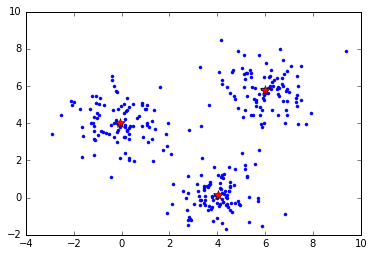

Iteration: 10
WSSSE = 362.741686164
Centroids: [array([ 4.0284519 ,  0.14377491]), array([ 5.97821446,  5.80188381]), array([-0.07896696,  4.0134803 ])]


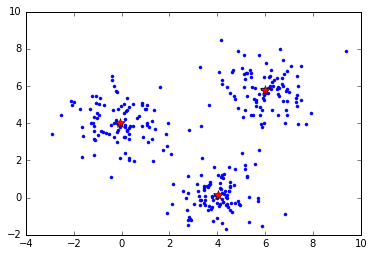

Iteration: 20
WSSSE = 362.741686164
Centroids: [array([ 4.0284519 ,  0.14377491]), array([ 5.97821446,  5.80188381]), array([-0.07896696,  4.0134803 ])]


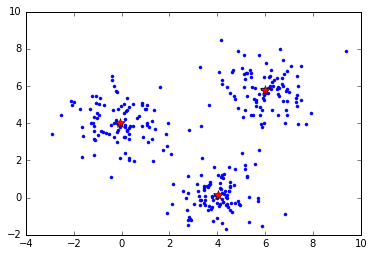

Iteration: 100
WSSSE = 362.741686164
Centroids: [array([ 4.0284519 ,  0.14377491]), array([ 5.97821446,  5.80188381]), array([-0.07896696,  4.0134803 ])]


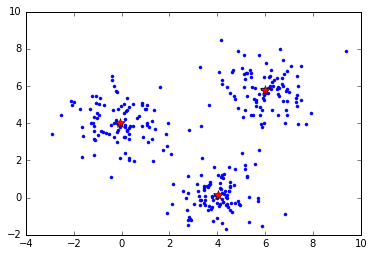

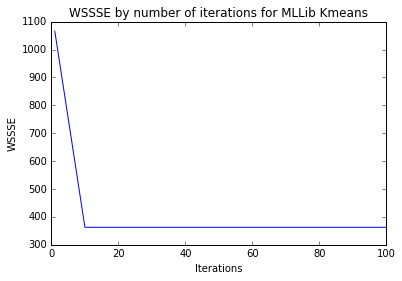

27.5389661789 seconds


In [17]:
from timeit import default_timer as timer

start = timer()

centroids_hg = np.array([[0.0,0.0],[2.0,2.0],[0.0,7.0]])

WSSSE_report = []
iterations = [1, 10, 20, 30, 40, 50, 100]

data = sc.textFile("data.csv").cache()

for i in range(100):
    centroids_hg_broadcast = sc.broadcast(centroids_hg)
    iteration = i + 1
    nearest_centroid_bound = partial(nearest_centroid_hg, centroids_hg_broadcast.value)
    error_bound = partial(error_hg, centroids_hg_broadcast.value)
    res = data.map(nearest_centroid_bound).reduceByKey(lambda x, y: (x[0] + y[0], x[1] + y[1])).collect()
    res = sorted(res, key = lambda x : x[0])  #sort based on clusted ID
    centroids_new_hg = np.array([x[1][0] / x[1][1] for x in res])  #divide by cluster size
    centroids_hg = centroids_new_hg
    WSSSE_hg = data.map(error_bound).reduceByKey(lambda x, y: x + y).collect()
    
    sum_WSSSE = 0
    
    for WSSSE in WSSSE_hg:
        sum_WSSSE += WSSSE[1]
    
    if iteration in [1, 10, 20, 100]:
        print("Iteration: " + str(iteration))
        print("WSSSE = " + str(sum_WSSSE))
        print("Centroids: " + str(clusters.centers))
        plot_iteration(clusters.centers)
    
    if iteration in iterations:
        WSSSE_report.append(sum_WSSSE)
        
plt.plot(iterations, WSSSE_report)
plt.title("WSSSE by number of iterations for MLLib Kmeans")
plt.xlabel("Iterations")
plt.ylabel("WSSSE")
plt.show()

end = timer()

print(str(end - start) + " seconds" )

### With this size of a dataset and running this locally, I don't see any significant change in runtime with broadcast. However, if running this on a Spark cluster sending the centroid information out to each cluster with the broadcast method should sigificantly reduce runtime. 

<a name="HW3.5"><h2 style="color:darkgreen"> HW3.5: OPTIONAL Weighted KMeans  </h2>
[Back to Table of Contents](#TOC)

Using this provided [homegrown Kmeans code](http://nbviewer.jupyter.org/urls/dl.dropbox.com/s/3nsthvp8g2rrrdh/EM-Kmeans.ipynb), modify it to do a weighted KMeans and repeat the experiements in HW3.3. Explain  any differences between the results in HW3.3 and HW3.5.

NOTE: Weight each example as follows using the inverse vector length (Euclidean norm): 

> weight(X)= 1/||X||, 

where ||X|| = SQRT(X.X)= SQRT(X1^2 + X2^2)

Here X is vector made up of two values X1 and X2.

__[Please incorporate all referenced notebooks directly into this master notebook as cells for HW submission. I.e., HW submissions should comprise of just one notebook]__

In [100]:
## Code goes here

In [101]:
## Drivers & Runners

In [102]:
## Run Scripts, S3 Sync

<a name="HW3.6"><h2 style="color:darkblue"> HW3.6 OPTIONAL Linear Regression</h2>
[Back to Table of Contents](#TOC)
<a name="HW3.6.1"><h2 style="color:darkblue"> HW3.6.1 OPTIONAL Linear Regression</h2>
[Back to Table of Contents](#TOC)

Using [this linear regression notebook](    http://nbviewer.jupyter.org/urls/dl.dropbox.com/s/atzqkc0p1eajuz6/LinearRegression-Notebook-Challenge.ipynb):


* Generate 2 sets of data with 100 data points using the data generation code provided and plot each in separate plots. Call one the training set and the other the testing set.

* Using MLLib's LinearRegressionWithSGD train up a linear regression model with the training dataset and evaluate with the testing set. What a good number of iterations for training the linear regression model? Justify with plots (e.g., plot MSE as a function of the number of iterations) and words. 


<a name="HW3.6.2"><h2 style="color:darkblue"> HW3.6.2 OPTIONAL Linear Regression</h2>
[Back to Table of Contents](#TOC)

In the notebook provided above, in the cell labeled "Gradient descent (regularization)".

* Fill in the blanks and get this code to work for LASS0 and RIDGE linear regression.

* Using the data from 3.6.1 tune the hyper parameters of your LASS0 and RIDGE regression. Report your findings with words and plots.

In [103]:
## Code goes here

In [104]:
## Drivers & Runners

In [105]:
## Run Scripts, S3 Sync

<a name="HW3.7"><h2 style="color:darkgreen"> HW3.7 OPTIONAL Error surfaces </h2>
[Back to Table of Contents](#TOC)

Here is a link to R code with 1 test drivers that plots the linear regression model in  model space and in the domain space:

> https://www.dropbox.com/s/3xc3kwda6d254l5/PlotModelAndDomainSpaces.R?dl=0

Here is a sample output from this script: 
      
> https://www.dropbox.com/s/my3tnhxx7fr5qs0/image%20%281%29.png?dl=0

Please use this as inspiration and code a equivalent error surface and heatmap (with isolines) in Spark and show the trajectory of learning taken during gradient descent(after each n-iterations of Gradient Descent):


Using Spark and  Python (using the above R Script as inspiration), plot the error surface for the linear regression model using a heatmap and contour plot. 
Also plot the current model in the original domain space for every 10th iteration.  Plot them side by side if possible  for each iteration: lefthand side plot is the model space(w0 and w01) and the righthand side plot is domain space (plot the corresponding model and training data in the problem domain space) with a final pair of graphs showing the entire trajectory in the model and domain space. Make sure to label your plots with iteration numbers, function, model space versus original domain space, MSE on the training data etc.

Also plot the MSE as a function of each iteration (possibly every 10th iteration). Dont forget to label both axis and the graph also. __[Please incorporate all referenced notebooks directly into this master notebook as cells for HW submission. I.e., HW submissions should comprise of just one notebook]__





In [106]:
## Code goes here

In [107]:
## Drivers & Runners

In [108]:
## Run Scripts, S3 Sync

[Back to Table of Contents](#TOC)
<center><div class='jumbotron'><h2 style='color:green'>-------  END OF HWK 9 --------</h2></div></center>